<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
  
warnings.filterwarnings('ignore')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

###Take a look at the data

In [3]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [4]:
df.shape

(23040, 21)

In [6]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [5]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

##Some data cleaning is certainly in order

Resolve missing data, make sure all categorical features are categorical, and numeric numeric.

In [0]:
# EASE_MENT and APARTMENT_NUMBER are 77% or more missing values, so just drop them
df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)

In [0]:
import numpy as np

In [0]:
# Remove commas from LAND_SQUARE_FEET before converting to float
# Also noticed one row is "########", so change to NaN
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','')
df[df['LAND_SQUARE_FEET'] == '########'] = np.NaN


In [0]:
# Convert to float, and replace NaN as 0 (assuming it means that they have no 
# land around them, not uncommon in NYC)
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].astype(float)
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].fillna(0)

In [0]:
# Now we can just drop the miscellaneous stragglers
df.dropna(inplace=True)

In [12]:
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [0]:
# Convert SALE_DATE to properly datetime format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'])

In [14]:
df.dtypes

BOROUGH                                  float64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                    float64
LOT                                      float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                         float64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                float64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                               float64
SALE_DATE                         datetime64[ns]
dtype: object

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# A few more numeric columns that should change, should be categorical, and not be computed
columns = ['ZIP_CODE', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'BLOCK', 'LOT']
for column in columns:
  df[column] = df[column].astype(str)



In [17]:
df.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                     object
LOT                                       object
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                  object
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                         float64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                                object
TAX_CLASS_AT_TIME_OF_SALE                 object
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                               float64
SALE_DATE                         datetime64[ns]
dtype: object

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [19]:
# Filter to only one family dwellings and between $100,000 and $2,000,000
cond = (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & \
       (df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)
df_subset = df[cond]

# Since that will no longer affect any model, drop that column
df_subset.drop(columns=['BUILDING_CLASS_CATEGORY'], inplace=True)
print(df_subset.shape)
df_subset.sample(5)

(3151, 18)


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7438,4.0,OTHER,1,4474.0,28.0,A2,147-43 7 AVENUE,11357.0,1.0,0.0,1.0,4040.0,1200.0,1950.0,1.0,A2,1117500.0,2019-02-06
9851,5.0,OTHER,1,5668.0,48.0,A5,261 GRANTWOOD AVENUE,10312.0,1.0,0.0,1.0,3650.0,1632.0,1980.0,1.0,A5,499000.0,2019-02-19
19869,3.0,OTHER,1,6702.0,78.0,A1,914 E 19TH STREET,11230.0,1.0,0.0,1.0,4000.0,2184.0,1910.0,1.0,A1,1380000.0,2019-04-09
16967,3.0,OTHER,1,7647.0,19.0,A1,1261 EAST 29TH STREET,11210.0,1.0,0.0,1.0,3238.0,2016.0,1925.0,1.0,A1,1400000.0,2019-03-26
20597,3.0,OTHER,1,6879.0,32.0,A5,8715 25TH AVENUE,11214.0,1.0,0.0,1.0,1740.0,1856.0,1950.0,1.0,A5,938000.0,2019-04-12


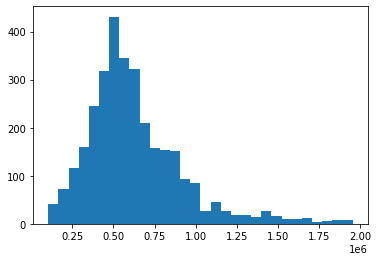

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_subset['SALE_PRICE'], bins=30);

In [21]:
# Split Jan - Mar into training, April on into testing
df_train = df_subset[df_subset['SALE_DATE'].dt.month <= 3]
df_test = df_subset[df_subset['SALE_DATE'].dt.month > 3]
df_train.shape, df_test.shape

((2507, 18), (644, 18))

In [22]:
df_train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507,2507
unique,5,6,2,2060,304,13,2497,122,86,1,11,68
top,4.0,OTHER,1,16350.0,20.0,A1,130-52 LEFFERTS BOULEVARD,10312.0,1920.0,1.0,A1,2019-01-31 00:00:00
freq,1204,2382,2476,17,46,919,2,115,290,2507,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [23]:
df_train.describe()

,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,SALE_PRICE
count,2507.000000,2507.000000,2507.000000,2507.000000,2507.000000,2.507000e+03
mean,0.987635,0.016354,1.003989,3146.051057,1473.744715,6.215737e+05
std,0.110532,0.129966,0.171794,1798.714872,599.217635,2.916072e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.040000e+05
25%,1.000000,0.000000,1.000000,2000.000000,1144.000000,4.405000e+05
50%,1.000000,0.000000,1.000000,2600.000000,1368.000000,5.600000e+05
75%,1.000000,0.000000,1.000000,4000.000000,1683.000000,7.500000e+05
max,1.000000,2.000000,3.000000,18906.000000,7875.000000,1.955000e+06


In [24]:
df_train.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

# We'll drop a number of features with high cardinality. 

Also, now drop the SALE_DATE column as, once used to split the data set, will choke the regressions.

In [0]:
df_train.drop(columns=['TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'YEAR_BUILT', 'SALE_DATE'], inplace=True)
df_test.drop(columns=['TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'YEAR_BUILT', 'SALE_DATE'], inplace=True)

In [26]:
df_train.head()

,BOROUGH,NEIGHBORHOOD,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE
44,3.0,OTHER,1.0,0.0,1.0,6800.0,1325.0,1.0,A9,550000.0
61,4.0,OTHER,1.0,0.0,1.0,4000.0,2001.0,1.0,A1,200000.0
78,2.0,OTHER,1.0,0.0,1.0,3500.0,2043.0,1.0,A1,810000.0
108,3.0,OTHER,1.0,0.0,1.0,4000.0,2680.0,1.0,A1,125000.0
111,3.0,OTHER,1.0,0.0,1.0,1710.0,1872.0,1.0,A5,620000.0


Seeing if neighborhood and borough are colinear. Hard to tell. On one hand, there is some correlatin; on the other hand, the unknown neighborhoods fall in all boroughs. I am keeping them both, as I think there is somewhat different information enough.

In [27]:
neighborhood_borough = pd.crosstab(df_train['NEIGHBORHOOD'], df_train['BOROUGH'])
neighborhood_borough

BOROUGH,1.0,2.0,3.0,4.0,5.0
NEIGHBORHOOD,,,,,
ASTORIA,0,0,0,11,0
BEDFORD STUYVESANT,0,0,8,0,0
BOROUGH PARK,0,0,12,0,0
FLUSHING-NORTH,0,0,0,77,0
FOREST HILLS,0,0,0,17,0
OTHER,1,242,378,1099,662


Hot one encode the remaining categorical features

In [0]:
import category_encoders as ce 

In [29]:
df_train.shape, df_test.shape

((2507, 10), (644, 10))

In [30]:

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
df_train = encoder.fit_transform(df_train)
df_test = encoder.transform(df_test)
df_train.shape, df_test.shape

((2507, 29), (644, 29))

In [31]:
df_train.sample(5)

,BOROUGH_3.0,BOROUGH_4.0,BOROUGH_2.0,BOROUGH_5.0,BOROUGH_1.0,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE_1.0,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,SALE_PRICE
14025,1,0,0,0,0,1,0,0,0,0,0,1.0,0.0,1.0,3250.0,860.0,1,0,0,0,0,1,0,0,0,0,0,0,585000.0
12531,0,0,0,1,0,1,0,0,0,0,0,1.0,0.0,1.0,1701.0,1240.0,1,0,0,1,0,0,0,0,0,0,0,0,460000.0
4872,1,0,0,0,0,1,0,0,0,0,0,1.0,0.0,1.0,1725.0,1726.0,1,0,1,0,0,0,0,0,0,0,0,0,991670.0
667,0,1,0,0,0,1,0,0,0,0,0,1.0,0.0,1.0,2000.0,864.0,1,0,0,1,0,0,0,0,0,0,0,0,685000.0
15021,0,1,0,0,0,1,0,0,0,0,0,1.0,0.0,1.0,4000.0,1150.0,1,0,0,0,0,1,0,0,0,0,0,0,997000.0


In [32]:
# See all features are now numeric
df_train.dtypes

BOROUGH_3.0                            int64
BOROUGH_4.0                            int64
BOROUGH_2.0                            int64
BOROUGH_5.0                            int64
BOROUGH_1.0                            int64
NEIGHBORHOOD_OTHER                     int64
NEIGHBORHOOD_FLUSHING-NORTH            int64
NEIGHBORHOOD_BEDFORD STUYVESANT        int64
NEIGHBORHOOD_FOREST HILLS              int64
NEIGHBORHOOD_BOROUGH PARK              int64
NEIGHBORHOOD_ASTORIA                   int64
RESIDENTIAL_UNITS                    float64
COMMERCIAL_UNITS                     float64
TOTAL_UNITS                          float64
LAND_SQUARE_FEET                     float64
GROSS_SQUARE_FEET                    float64
TAX_CLASS_AT_TIME_OF_SALE_1.0          int64
BUILDING_CLASS_AT_TIME_OF_SALE_A9      int64
BUILDING_CLASS_AT_TIME_OF_SALE_A1      int64
BUILDING_CLASS_AT_TIME_OF_SALE_A5      int64
BUILDING_CLASS_AT_TIME_OF_SALE_A0      int64
BUILDING_CLASS_AT_TIME_OF_SALE_A2      int64
BUILDING_C

In [0]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

def findKBest(df_train, df_test, target, max_k):
  '''
  Find the best K value

  Inputs:
  df_train - train data (including target feature)
  df_test - test data
  target - the column with the target values
  max_k - the maximum we want to try

  Outputs:
  Table of k values and metrics
  The best k value by minimum MAE
  '''

  # Split features and target in training and testing data
  X_train = df_train.drop(target, axis=1)
  y_train = df_train[target]
  X_test = df_test.drop(target, axis=1)
  y_test = df_test[target]

  # Loop through values of k from 1 to max_k
  metrics = []
  kvalues = []
  minimum = np.infty
  for k in range(1, max_k):

    # Fit and transform SelectKBest on training and test data
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_kbest = selector.fit_transform(X_train, y_train)
    X_test_kbest = selector.transform(X_test)

    # Train model on the selected features
    model = LinearRegression()
    model.fit(X_train_kbest, y_train)
    y_predict = model.predict(X_test_kbest)

    # Calculate MAE and store results. Find minimums.
    mae = mean_absolute_error(y_test, y_predict)
    if mae < minimum:
      minimum = mae
      best_k = k
    metrics.append(mae)
    kvalues.append(k)

  metrics_table = pd.DataFrame({'K':kvalues, 'MAE':metrics}, index=range(max_k-1))
  return metrics_table, minimum, best_k


In [34]:
# See what result our data gets
results = findKBest(df_train, df_test, 'SALE_PRICE', df_train.shape[1])
print(f'\n\nbest k = {results[2]}\nlowest mae = {results[1]}\n\n')
results[0]





best k = 19
lowest mae = 166550.72137249738




,K,MAE
0,1,183640.585801
1,2,179554.768430
2,3,179291.466583
3,4,170482.971122
4,5,169982.368482
5,6,168638.311124
6,7,168301.526551
7,8,167193.109389
8,9,167506.409784
9,10,167477.989631


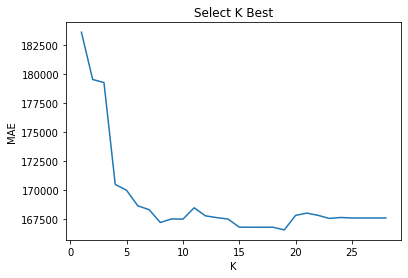

In [35]:
plt.plot(results[0]['K'], results[0]['MAE'])
plt.title('Select K Best')
plt.xlabel('K')
plt.ylabel('MAE');

In [53]:
# Use our best suggestion on K value
X_train = df_train.drop('SALE_PRICE', axis=1)
X_test = df_test.drop('SALE_PRICE', axis = 1)
y_train = df_train['SALE_PRICE']
y_test = df_test['SALE_PRICE']

selector = SelectKBest(score_func=f_regression, k=results[2])
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

columns_kbest = X_train.columns[selector.get_support()].tolist()
columns_kbest

['BOROUGH_3.0',
 'BOROUGH_4.0',
 'BOROUGH_2.0',
 'BOROUGH_5.0',
 'NEIGHBORHOOD_OTHER',
 'NEIGHBORHOOD_FLUSHING-NORTH',
 'NEIGHBORHOOD_FOREST HILLS',
 'NEIGHBORHOOD_BOROUGH PARK',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
 'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
 'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
 'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
 'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
 'BUILDING_CLASS_AT_TIME_OF_SALE_S0']

In [0]:
from sklearn.linear_model import Ridge, RidgeCV

def findAlpha(df_train, df_test, target, alpha_range):
  '''
  Find the optimum alpha for ridge regression
  Inputs:
  df_train - train data (incl. target column)
  df_test - test data
  target - column with target value
  alpha_range - a range to values to try

  Output:
  Tabular results, and 'best' choice given minimum error
  '''

  # Split into features and target
  X_train = df_train.drop(target, axis=1)
  y_train = df_train[target]
  X_test = df_test.drop(target, axis=1)
  y_test = df_test[target]

  # Loop through alpha values and find 'best'
  maes = []
  alphas = []
  minimum = np.infty
  best_alpha = 0
  for i, alpha in enumerate(alpha_range):
    # Construct model
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)

    # Predict test data and obtain results
    y_predict_r = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_predict_r)
    if mae < minimum:
      minimum = mae
      best_alpha = alpha
    maes.append(mae)
    alphas.append(alpha)

  metrics_table = pd.DataFrame({'alpha':alphas, 'MAE':maes}, 
                               index=range(len(alpha_range)))
  return metrics_table, minimum, best_alpha

In [55]:
# Try our data
# For the function happy, SALE_PRICE needs to go with our chosen features
columns_kbest2 = columns_kbest.copy()
columns_kbest2.append('SALE_PRICE')  

alphas = [0.001, 0.01, .1, 1.0, 10.0, 100.0]
result1 = findAlpha(df_train[columns_kbest2], 
                    df_test[columns_kbest2], 'SALE_PRICE', 
                    alphas)
print(f'\n\nBest alpha = {result1[2]}\nVariance = {result1[1]}\n\n')
result1[0]





Best alpha = 0.001
Variance = 166646.74963689534




,alpha,MAE
0,0.001,166646.749637
1,0.010,166668.384993
2,0.100,167104.887576
3,1.000,175226.294770
4,10.000,201172.442082
5,100.000,210275.900867


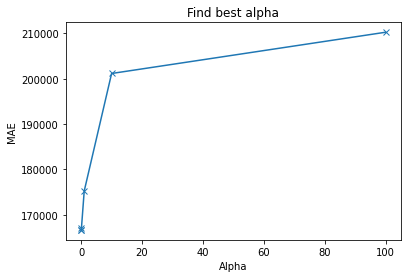

In [56]:
plt.plot(result1[0]['alpha'], result1[0]['MAE'], 'x-')
plt.title('Find best alpha')
plt.xlabel('Alpha')
plt.ylabel('MAE');

This will compare the metrics for linear vs. ridge regression, for both the training and testing data.

In [0]:
def compareRegressions(df_train, df_test, target, alpha):

  X_train = df_train.drop(target, axis=1)
  X_test = df_test.drop(target, axis=1)
  y_train = df_train[target]
  y_test = df_test[target]

  output = {}

  # Construct ridge regression
  model3 = Ridge(alpha, normalize=True)
  model3.fit(X_train, y_train)

  # Get metrics for training and testing data
  y_predict_rtrain = model3.predict(X_train)
  mae_rtrain = mean_absolute_error(y_train, y_predict_rtrain)
  y_predict_rtest = model3.predict(X_test)
  mae_rtest = mean_absolute_error(y_test, y_predict_rtest)
  output['ridge'] = [mae_rtrain, mae_rtest]

  # Linear regression
  model4 = LinearRegression()
  model4.fit(X_train, y_train)

  # Get metrics for training and testing data
  y_predict_ltrain = model4.predict(X_train)
  mae_ltrain = mean_absolute_error(y_train, y_predict_ltrain)
  y_predict_ltest = model4.predict(X_test)
  mae_ltest = mean_absolute_error(y_test, y_predict_ltest)
  output['linear'] = [mae_ltrain, mae_ltest]

  return pd.DataFrame(output, index=['train', 'test'])


In [58]:
compareRegressions(df_train[columns_kbest2], df_test[columns_kbest2], 'SALE_PRICE',
                   result1[2])


,ridge,linear
train,164771.453516,164720.811303
test,166646.749637,166550.721372


Not being sure how to choose the optimal lambda (alpha), we can also compare a range of values.

In [59]:
from IPython.display import display

data = {}
for alpha in [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]:
  output = compareRegressions(df_train[columns_kbest2], df_test[columns_kbest2], 
                              'SALE_PRICE', alpha)
  print(f'Alpha = {alpha}')
  display(output)
  print('\n\n')


Alpha = 0.001


,ridge,linear
train,164771.453516,164720.811303
test,166646.749637,166550.721372





Alpha = 0.01


,ridge,linear
train,164743.093247,164720.811303
test,166668.384993,166550.721372





Alpha = 0.1


,ridge,linear
train,164567.194031,164720.811303
test,167104.887576,166550.721372





Alpha = 1.0


,ridge,linear
train,173626.841647,164720.811303
test,175226.294770,166550.721372





Alpha = 10.0


,ridge,linear
train,203238.644824,164720.811303
test,201172.442082,166550.721372





Alpha = 100.0


,ridge,linear
train,213300.417070,164720.811303
test,210275.900867,166550.721372


## Ah-ha! 

Use GridSearchCV to find the best alpha for ridge regression.

In [61]:
from sklearn.model_selection import GridSearchCV

alphas = [0.001, 0.01, 0.1, 1, 1.0, 10.0, 100.0]
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train[columns_kbest], y_train)

print(f'Best score = {grid.best_score_}\nBest alpha = {grid.best_estimator_.alpha}')

Best score = 0.362123982588168
Best alpha = 10.0


OK, we'll use their advice (even if redundant now).

In [63]:
compareRegressions(df_train[columns_kbest2], df_test[columns_kbest2], 'SALE_PRICE',
                   grid.best_estimator_.alpha)

,ridge,linear
train,203238.644824,164720.811303
test,201172.442082,166550.721372


##Comparing Ridge and Linear regressions on a single feature.

1. Find univariate feature using SelectKBest 

2. Select optimum alpha for ridge regression

3. Run ridge and linear regression, and compare result









In [45]:
# Which singular feature would be suggested by selectKBest
selector = SelectKBest(score_func=f_regression, k=1)
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

X_train.columns[selector.get_support()]

Index(['GROSS_SQUARE_FEET'], dtype='object')

In [46]:
# Try a range of alphas for ridge regression
alphas = [0.001, 0.01, .1, 1.0, 10.0, 100.0]
result2 = findAlpha(df_train[['GROSS_SQUARE_FEET', 'SALE_PRICE']], 
                   df_test[['GROSS_SQUARE_FEET', 'SALE_PRICE']], 'SALE_PRICE', 
                   alphas)
print(f'\n\nBest alpha = {result2[2]}\nMAE = {result2[1]}\n\n')
result2[0]





Best alpha = 0.001
MAE = 183647.96292974034




,alpha,MAE
0,0.001,183647.962930
1,0.010,183713.699718
2,0.100,184495.067827
3,1.000,192591.825290
4,10.000,207442.865842
5,100.000,211099.876018


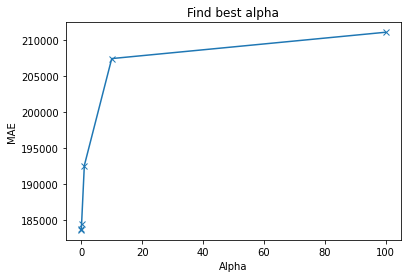

In [47]:
plt.plot(result2[0]['alpha'], result2[0]['MAE'], 'x-')
plt.title('Find best alpha')
plt.xlabel('Alpha')
plt.ylabel('MAE');

In [0]:
# Make a function so we can try other alpha values
def tryAlpha(alpha):
  # Construct ridge regression
  model1 = Ridge(alpha, normalize=True)
  model1.fit(X_train[['GROSS_SQUARE_FEET']], y_train)

  # Get metrics and print
  y_predict1 = model1.predict(X_test[['GROSS_SQUARE_FEET']])
  mae1 = mean_absolute_error(y_test, y_predict1)
  print(f'Ridge Regression:\nF(X) = {round(model1.coef_[0], 3)}X + {round(model1.intercept_, 3)}')
  print (f'Mean Abs. Error = {mae1}')

  # Linear regression
  model2 = LinearRegression(normalize=True)
  model2.fit(X_train[['GROSS_SQUARE_FEET']], y_train)

  # Get metrics and print
  y_predict2 = model2.predict(X_test[['GROSS_SQUARE_FEET']])
  mae2 = mean_absolute_error(y_test, y_predict2)
  print(f'\nLinear Regression:\nF(X) = {round(model2.coef_[0], 3)}X + {round(model2.intercept_, 3)}')
  print (f'Mean Abs. Error = {mae2}\n\n')

  # Plot to compare visually
  fig = plt.figure(figsize=(10,7))
  plt.scatter(X_test['GROSS_SQUARE_FEET'], y_test, alpha=.4)
  plt.plot(X_test['GROSS_SQUARE_FEET'], y_predict1, color='red', label='Ridge regression')
  plt.plot(X_test['GROSS_SQUARE_FEET'], y_predict2, color='gray', label='Linear regression')
  plt.axhline(y_test.mean(), color='green', dashes=(1,2), label='Mean')
  plt.title('Comparison Ridge and Linear regressions, mean')
  plt.xlabel('GROSS SQUARE FEET')
  plt.ylabel('SALE PRICE')
  plt.legend()
  plt.show()

Ridge Regression:
F(X) = 220.92X + 295993.729
Mean Abs. Error = 183647.96292974034

Linear Regression:
F(X) = 221.141X + 295668.149
Mean Abs. Error = 183640.5858012459




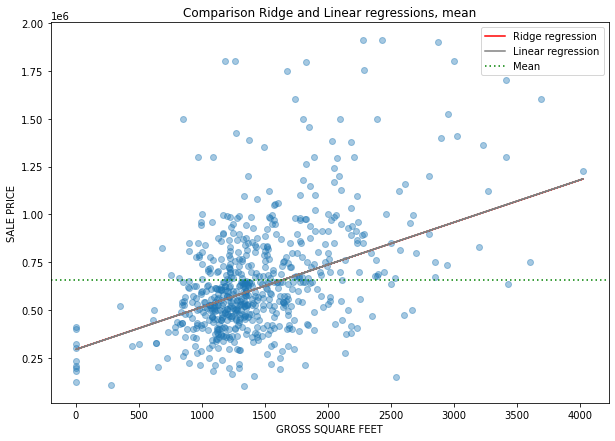

In [49]:
# Check our best suggestion on alpha
tryAlpha(result2[2])

Using the optimum alpha determined in the function to previously, there is not perceptible difference in the two lines. We can try different alphas to observe the divergence.

Alpha = 0.1
Ridge Regression:
F(X) = 201.037X + 325295.93
Mean Abs. Error = 184495.0678270217

Linear Regression:
F(X) = 221.141X + 295668.149
Mean Abs. Error = 183640.5858012459




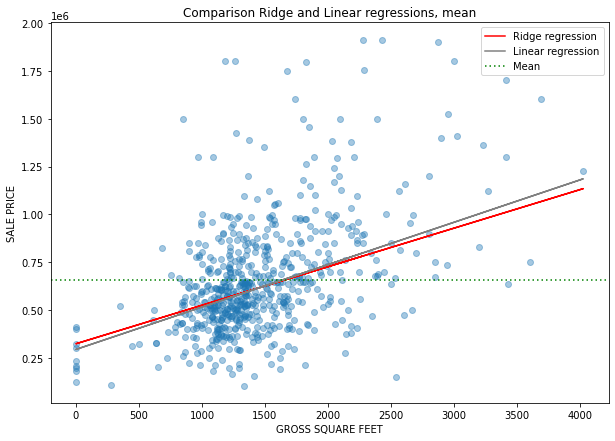

Alpha = 1.0
Ridge Regression:
F(X) = 110.571X + 458620.946
Mean Abs. Error = 192591.8252899977

Linear Regression:
F(X) = 221.141X + 295668.149
Mean Abs. Error = 183640.5858012459




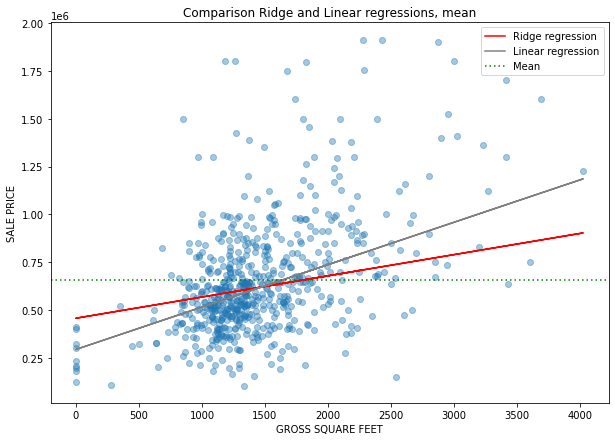

Alpha = 10.0
Ridge Regression:
F(X) = 20.104X + 591945.961
Mean Abs. Error = 207442.86584198786

Linear Regression:
F(X) = 221.141X + 295668.149
Mean Abs. Error = 183640.5858012459




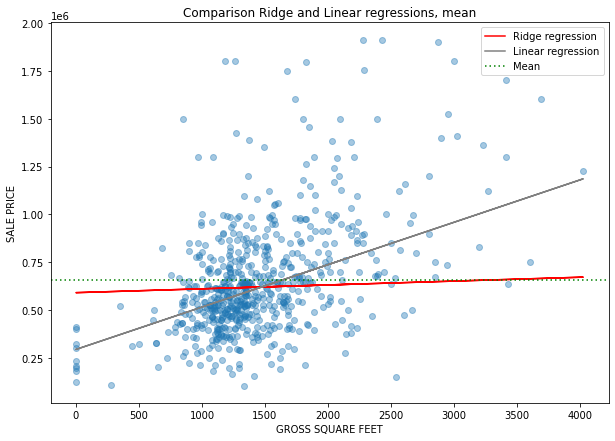

Alpha = 100.0
Ridge Regression:
F(X) = 2.19X + 618346.954
Mean Abs. Error = 211099.87601801296

Linear Regression:
F(X) = 221.141X + 295668.149
Mean Abs. Error = 183640.5858012459




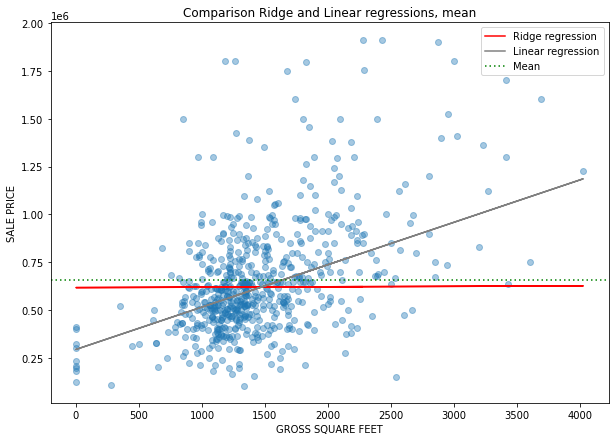

In [50]:
for a in [0.1, 1.0, 10.0, 100.0]:
  print(f'Alpha = {a}')
  tryAlpha(a)

Using GridSearchCV tells us the best alpha in the range given it to be 100. Parallel with the baseline? 

In [51]:
from sklearn.model_selection import GridSearchCV

alphas = [0.001, 0.01, 0.1, 1, 1.0, 10.0, 100.0]
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))
grid.fit(X_train[['GROSS_SQUARE_FEET']], y_train)

print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.19725551169250694
100.0
